# Libreria *xplique*

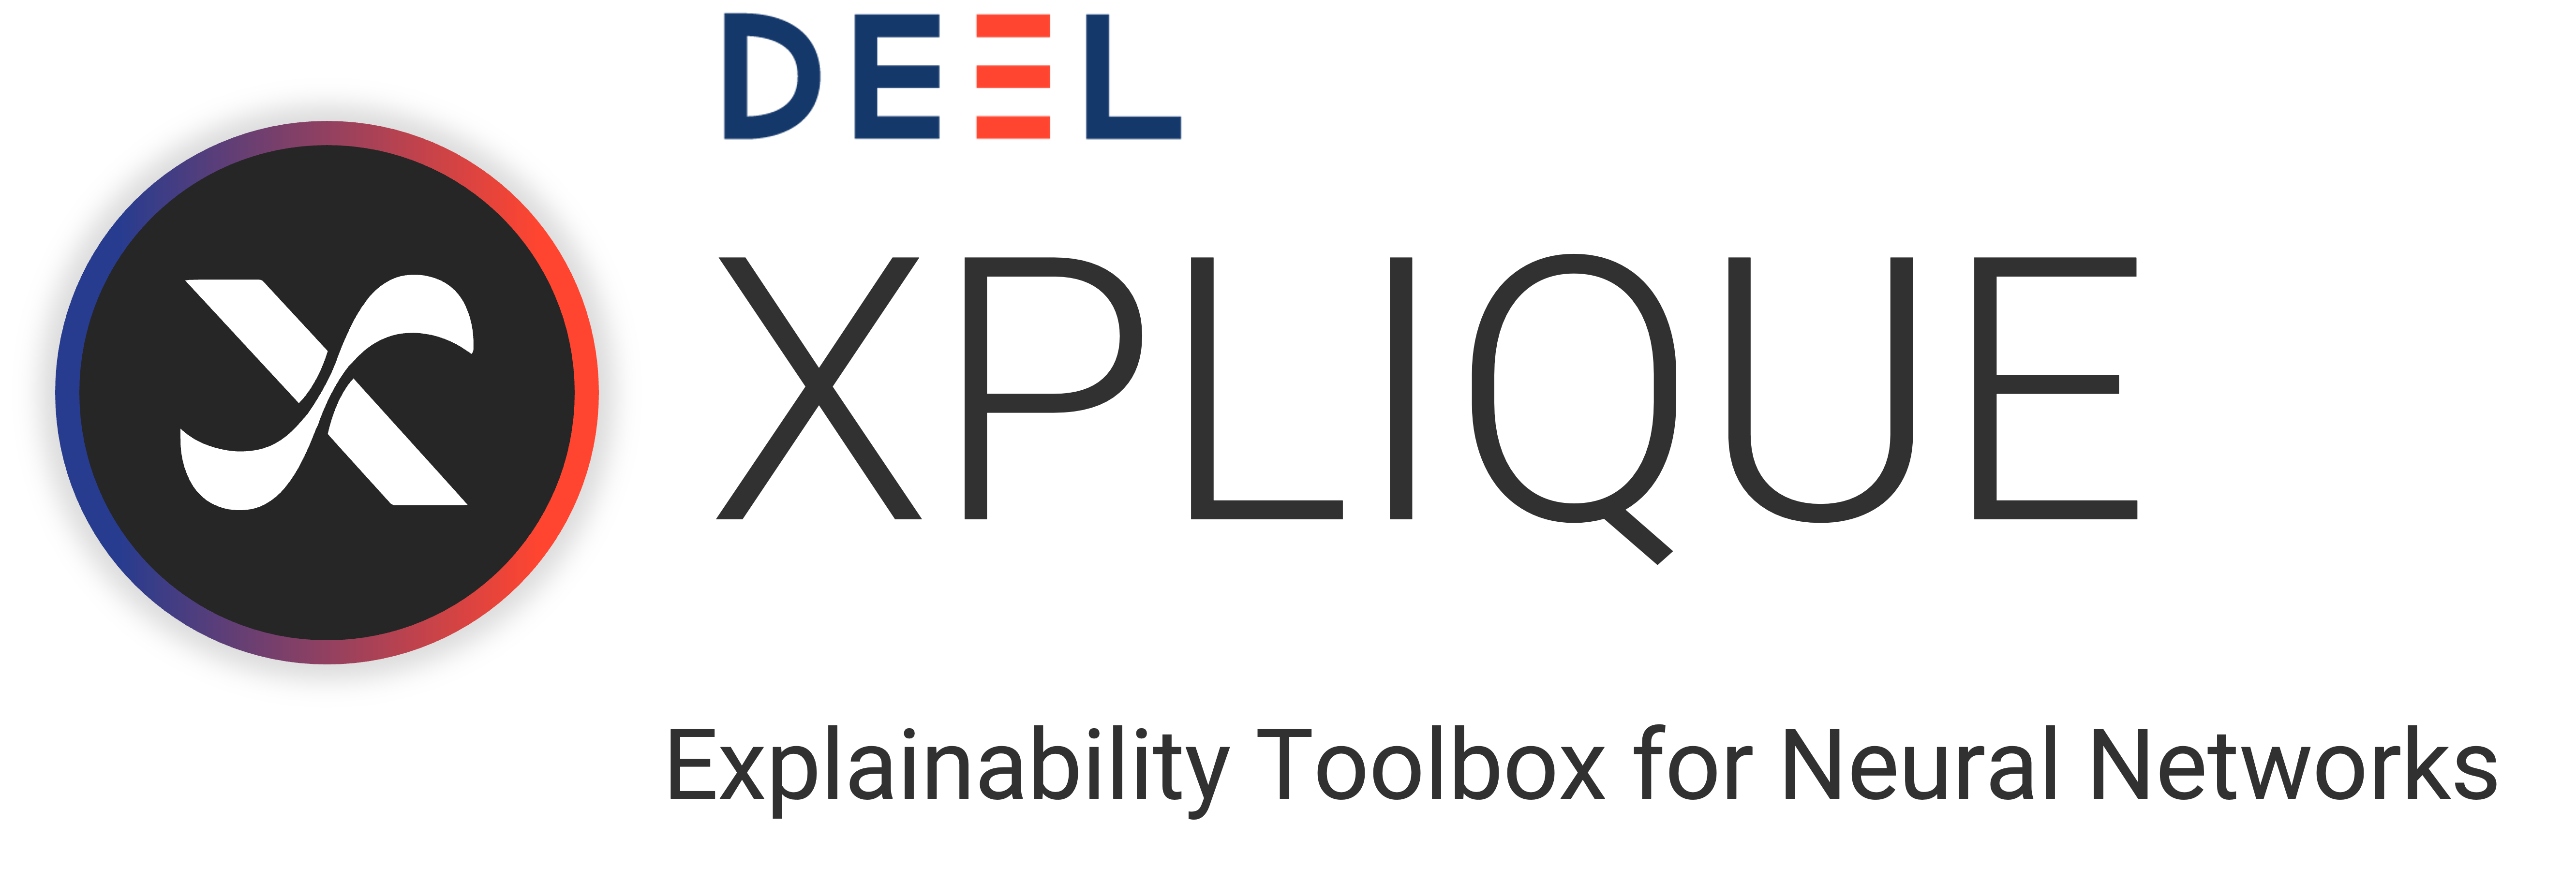

The xplique library is a powerful tool for Explainable AI (XAI) designed to provide transparent and comprehensible explanations for machine learning models. It implements a variety of explanation techniques, including Grad-CAM, Integrated Gradients, and Saliency Maps, allowing users to effectively analyze and interpret the behavior of their models. Additionally, xplique offers methods to evaluate the effectiveness of different XAI techniques, facilitating comparisons between approaches and ensuring a deeper understanding of model decisions. These features make xplique an invaluable resource for researchers and professionals seeking to enhance the transparency and reliability of their models in academic and practical applications.

### Disclaimer
The majority of the text and code presented in this notebook is derived from or inspired by the official documentation of the xplique library. For a comprehensive understanding and further details on the implementation and usage of xplique, please refer to the official [documentation](https://github.com/deel-ai/xplique/tree/master?tab=readme-ov-file).

In [1]:
!pip install -U -q xplique

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.7/267.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.1 which is incompatible.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

import xplique
from xplique.attributions import IntegratedGradients, GuidedBackprop
from xplique.plots import plot_attributions

### Dataset loading and preprocessing

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)).astype('float32') / 255.0
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)).astype('float32') / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
input_layer = layers.Input(shape=(28, 28, 1))

flattened = layers.Flatten()(input_layer)
dense_1 = layers.Dense(128, activation='relu')(flattened)
output_layer = layers.Dense(10, activation='softmax')(dense_1)
model = keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')


Epoch 1/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2793 - accuracy: 0.9215 - val_loss: 0.1562 - val_accuracy: 0.9533
Epoch 2/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1226 - accuracy: 0.9643 - val_loss: 0.1093 - val_accuracy: 0.9677
Epoch 3/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0848 - accuracy: 0.9748 - val_loss: 0.0970 - val_accuracy: 0.9721
Epoch 4/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0646 - accuracy: 0.9807 - val_loss: 0.0952 - val_accuracy: 0.9718
Epoch 5/5
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0500 - accuracy: 0.9852 - val_loss: 0.0891 - val_accuracy: 0.9735
313/313 - 1s - loss: 0.0911 - accuracy: 0.9717 - 606ms/epoch - 2ms/step

Test accuracy: 0.9717


In [5]:
index = 0
test_image = x_test[index:index + 1]

predicted_class = np.argmax(model.predict(test_image), axis=-1)
print(f'Predicted class: {predicted_class[0]}')

y = y_test[0]

1/1 [==============================] - 0s 82ms/step
Predicted class: 7


## Feature attribution methods

The main objective in attributions techniques is to highlight the discriminating variables for decision-making. For instance, with Computer Vision (CV) tasks, the main goal is to underline the pixels contributing the most in the input image(s) leading to the model’s output(s).

### Back-Propagation Methods

Back-propagation methods are one of the two groups of attribution methods with perturbation based methods. Those methods use the weights of the model to back-propagate the importance from the prediction (class activation or regression) to the inputs. It was first introduced in 2013, with the saliency method from <a href="https://arxiv.org/abs/1312.6034">Simonyan et al</a>.

### Guided Backpropagation

The saliency method is the first gradient-based method, thus the simpliest. The importance is given by the absolute value of the gradient (for a given class).

$$ \phi_c(x) = |\frac{\delta S_c(x)}{\delta x}| $$

The guided-backpropagation method modify the model so that for relu activations, only the positive gradients from positive activations are backpropagated. The formula is thus the same as Saliency but the behavior on relu activations differ.

### Practical Implementation

Methods default values, common for all methods.

```python
explainer = GuidedBackprop(model,
                     output_layer: Union[str, int] = None,
                     batch_size: int = 32)
```

- The `output_layer` parameter is the index or name of the output layer corresponding to the label layer. The last layer layers can be activated (linear, softmax ...).

- The `batch_size` define the number of inputs to treat simultaneously. (Positive integer).

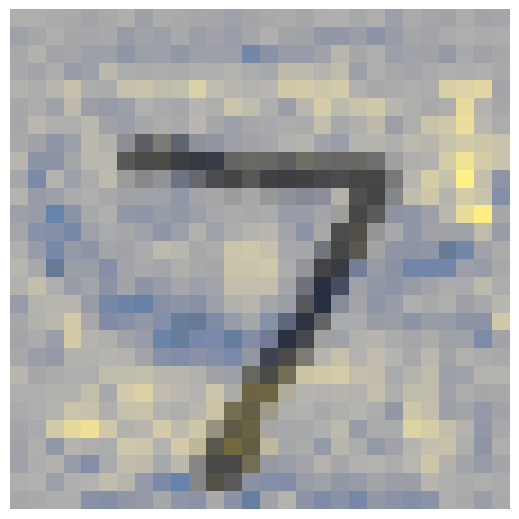

In [6]:
import tensorflow as tf

explainer = GuidedBackprop(model, output_layer=None, batch_size=1)

explanation = explainer.explain(test_image, np.array([predicted_class]))

plot_attributions(explanation, test_image, img_size=5, cmap='cividis', cols=1, alpha=0.6)

### Integrated Gradients

Integrated Gradients is a visualization technique resulting of a theoretical search for an explanatory method that satisfies two axioms, Sensitivity and Implementation Invariance (Sundararajan et al.).

<a href="https://arxiv.org/abs/1703.01365"> Sundararajan et al. 2017</a>: "*We consider the straightline path (in $R^n$) from the baseline $\bar{x}$ to the input $x$, and compute the gradients at all points along the path. Integrated gradients are obtained by cumulating these gradients.*"

Rather than calculating only the gradient relative to the image, the method consists of averaging the gradient values along the path from a baseline state to the current input sample $x$. The baseline state is often set to zero, representing the complete absence of features.

More precisely, with $\bar{x}$ the baseline state, $x$ the image, $c$ the class of interest and $S_c$ the unormalized class score (layer before softmax). The Integrated Gradient is defined as

$$IG(x) = (x - \bar{x}) \cdot \int_0^1{ \frac { \partial{S_c(\bar{x} + \alpha(x - \bar{x}))} } { \partial{x} } d\alpha }$$

In order to approximate from a finite number of steps, the implementation here use the Trapezoidal rule (<a href="https://en.wikipedia.org/wiki/Trapezoidal_rule">wikipedia</a>)  and not a left-Riemann summation, which allows for more accurate results and improved performance. (see <a href="https://arxiv.org/abs/1908.06214">Sotoudeh et Thakur - 2019</a> for a comparison of the methods).

### Practical implementation

```python
explainer = IntegratedGradients(model,
                                output_layer: int = -1,
                                batch_size: int = 32,
                                steps: int = 50,
                                baseline_value: float = .0)
```

- The `output_layer` parameter is the index of the output layer corresponding to the label layer. The last layer layers can be activated (linear, softmax ...).

- The `batch_size` define the number of inputs to treat simultaneously. (Positive integer).

- The `steps` parameter is the number of points to interpolate between the baseline and the desired point. The value of `steps` has an linear impact on the simulation time. (Positive integer).

- The `baseline_value` parameter is a scalar used to create the baseline point.

The choices of `steps` and `baseline_value` are related to each other.

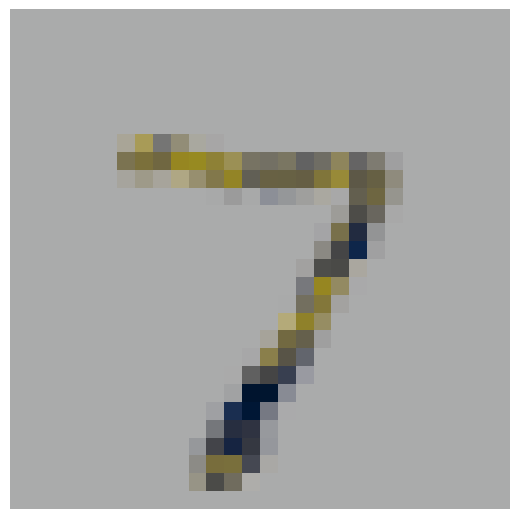

In [7]:
explainer = IntegratedGradients(model,
                                output_layer=None, batch_size=1,
                                steps=50, baseline_value=0)

explanation = explainer.explain(test_image, np.array([y]))

plot_attributions(explanation, test_image, img_size=5, cmap='cividis', cols=1, alpha=0.6)

# 📕 Exercise

1. Take the MNIST Dataset (or another image dataset)
2. Train a DL model
3. Try to explain the predictions with SHAP and LIME (you can use the native libraries or xplique)
4. Compare the generated heatmaps with those from Integrated Gradients and Guided BackPropagation